# Trinomial Option Tree Model

#### Trinomial Tree Model for pricing European call and put options. The trinomial tree is a discrete-time model used to approximate the evolution of stock prices over time and is an extension of the binomial tree. This script does the following: 
	•Constructs a trinomial tree to simulate stock prices.
	•Uses backward induction to compute the option price at each node.
	•Visualizes the tree structure using NetworkX and Matplotlib.
	•Computes both European Call and Put Option Prices.

#### Logic:
	•The up factor  u  and down factor  d  are computed as:

$$u = e^{\lambda \sigma \sqrt{\frac{T}{N}}}$$


$$ d = \frac{1}{u}$$


	•Compute risk-neutral probabilities:

$$ p_u = \frac{1}{2 \lambda^2} + \frac{(r - \frac{\sigma^2}{2}) \sqrt{dt}}{2 \lambda \sigma}$$


$$p_m = 1 - \frac{1}{\lambda^2}$$


$$p_d = 1 - p_u - p_m$$

    •Computes payoffs at terminal nodes:
    
$$ Call:  \max(S - K, 0) $$
$$ Put:   \max(K - S, 0) $$

	•Perform backward induction to calculate option price at earlier nodes using:

 $$V_i = \frac{p_d V_{i,d} + p_m V_{i,m} + p_u V_{i,u}}{e^{r dt}}$$

#### Output: 

	•A trinomial tree visualization of stock price evolution.
	•A call option tree with values at each node.
	•A put option tree with values at each node.

In [99]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

In [107]:
def construct_labels(initial_price, N, T, sigma, lambdA):
    """Constructs trinomial tree stock prices"""
    u = np.exp(lambdA * sigma * np.sqrt(T / N))  # Up factor
    d = 1 / u  # Down factor
    m = 1  # No movement (middle factor)
    
    print(f"Up factor (u): {u}, Down factor (d): {d}, Middle (m): {m}")  # Debugging

    list_node = {'layer0': [initial_price]}  # Initialize tree with S0

    # Generate tree layers
    for layer in range(1, N + 1):
        cur_layer = []  

        # Generate prices for this layer
        for i in range(layer + 1):
            price = initial_price * (d ** (layer - i)) * (u ** i)  # Apply down & up factors
            cur_layer.append(price)

        list_node[f'layer{layer}'] = cur_layer  # Store computed prices

    return list_node

In [109]:
def construct_Ecallput_node(list_node, K, N, r, T, lambdA, sigma, call_put):
    dt = T / N
    erdt = np.exp(r * dt)

    # Fixing the probability calculations
    pu = 1 / (2 * lambdA**2) + (r - sigma**2 / 2) * np.sqrt(dt) / (2 * lambdA * sigma)
    pm = 1 - 1 / lambdA**2
    pd = 1 - pu - pm

    # Store the last layer of the list_node to a new list
    last_layer = list_node['layer' + str(N)]

    # Calculate option values at final nodes
    if call_put == 'call':
        last_layer = np.subtract(last_layer, K)
    else:
        last_layer = np.subtract(K, last_layer)

    last_layer = [max(ele, 0) for ele in last_layer]

    # Dictionary to store option values
    call_node = {'layer' + str(N): last_layer}

    # Backward induction to calculate earlier layers
    for layer in reversed(range(N)):
        cur_layer = []
        propagate_layer = call_node['layer' + str(layer + 1)]

        # Compute option values for the current layer
        for ele in range(len(propagate_layer) - 2):  
            val = (propagate_layer[ele] * pd +
                   propagate_layer[ele + 1] * pm +
                   propagate_layer[ele + 2] * pu) / erdt
            cur_layer.append(np.round(val, 10))

        # Store computed layer
        call_node['layer' + str(layer)] = cur_layer

    return call_node

In [111]:
def construct_nodelabel(list_node, N):
    # Construct a dictionary to store labels
    nodelabel = {}

    # Loop through each layer
    for layer in range(N + 1):
        # Loop through each node in the current layer
        for ele in range(len(list_node['layer' + str(layer)])):
            # Create a dictionary entry for each node
            dict_data = {str(layer) + str(ele): round(list_node['layer' + str(layer)][ele], 2)}
            nodelabel.update(dict_data)

    return nodelabel  # Return the dictionary of node labels


In [113]:
def construct_node(node_list, N):
    """Constructs a graph from a binomial tree node list"""
    G = nx.Graph()  # Initialize the graph

    # Loop through each layer
    for layer in range(N):
        # Store the current layer
        cur_layer = node_list['layer' + str(layer)]
        
        # For each element in the current layer, connect to the next layer
        for ele in range(len(cur_layer)):
            G.add_edge(str(layer) + str(ele), str(layer + 1) + str(ele))
            G.add_edge(str(layer) + str(ele), str(layer + 1) + str(ele + 1))

            # Ensure we do not add an edge beyond the valid range
            if ele + 2 < len(node_list['layer' + str(layer + 1)]):
                G.add_edge(str(layer) + str(ele), str(layer + 1) + str(ele + 2))
    
    return G  # Return the constructed graph


In [115]:
def construct_nodepos(node_list):
    position = {}  # Dictionary to store node positions

    for layer in range(len(node_list)):  # Loop through each layer
        cur_layer = node_list[f'layer{layer}']  
        num_nodes = len(cur_layer)

        # Centering nodes horizontally: Equilateral positioning
        x_offset = - (num_nodes - 1) / 2  # Shift to center each row

        for i in range(num_nodes):
            position[f'{layer}{i}'] = (layer, x_offset + i)  # (X, Y) positioning

    return position  # Return the updated node positions

Stock Price - S (Default: 50) -->  50
Strike Price - K (Default: 50) -->  52
Volatility - sigma (Default: 0.2) -->  0.2
Time to Maturity - T (Default: 0.5) -->  0.5
Periods (Default: 6) -->  6
Interest Rate - r (Default: 0.04) -->  0.04
Lambda (Default: 1.5) -->  1.5


Up factor (u): 1.0904631784921235, Down factor (d): 0.9170415101799084, Middle (m): 1


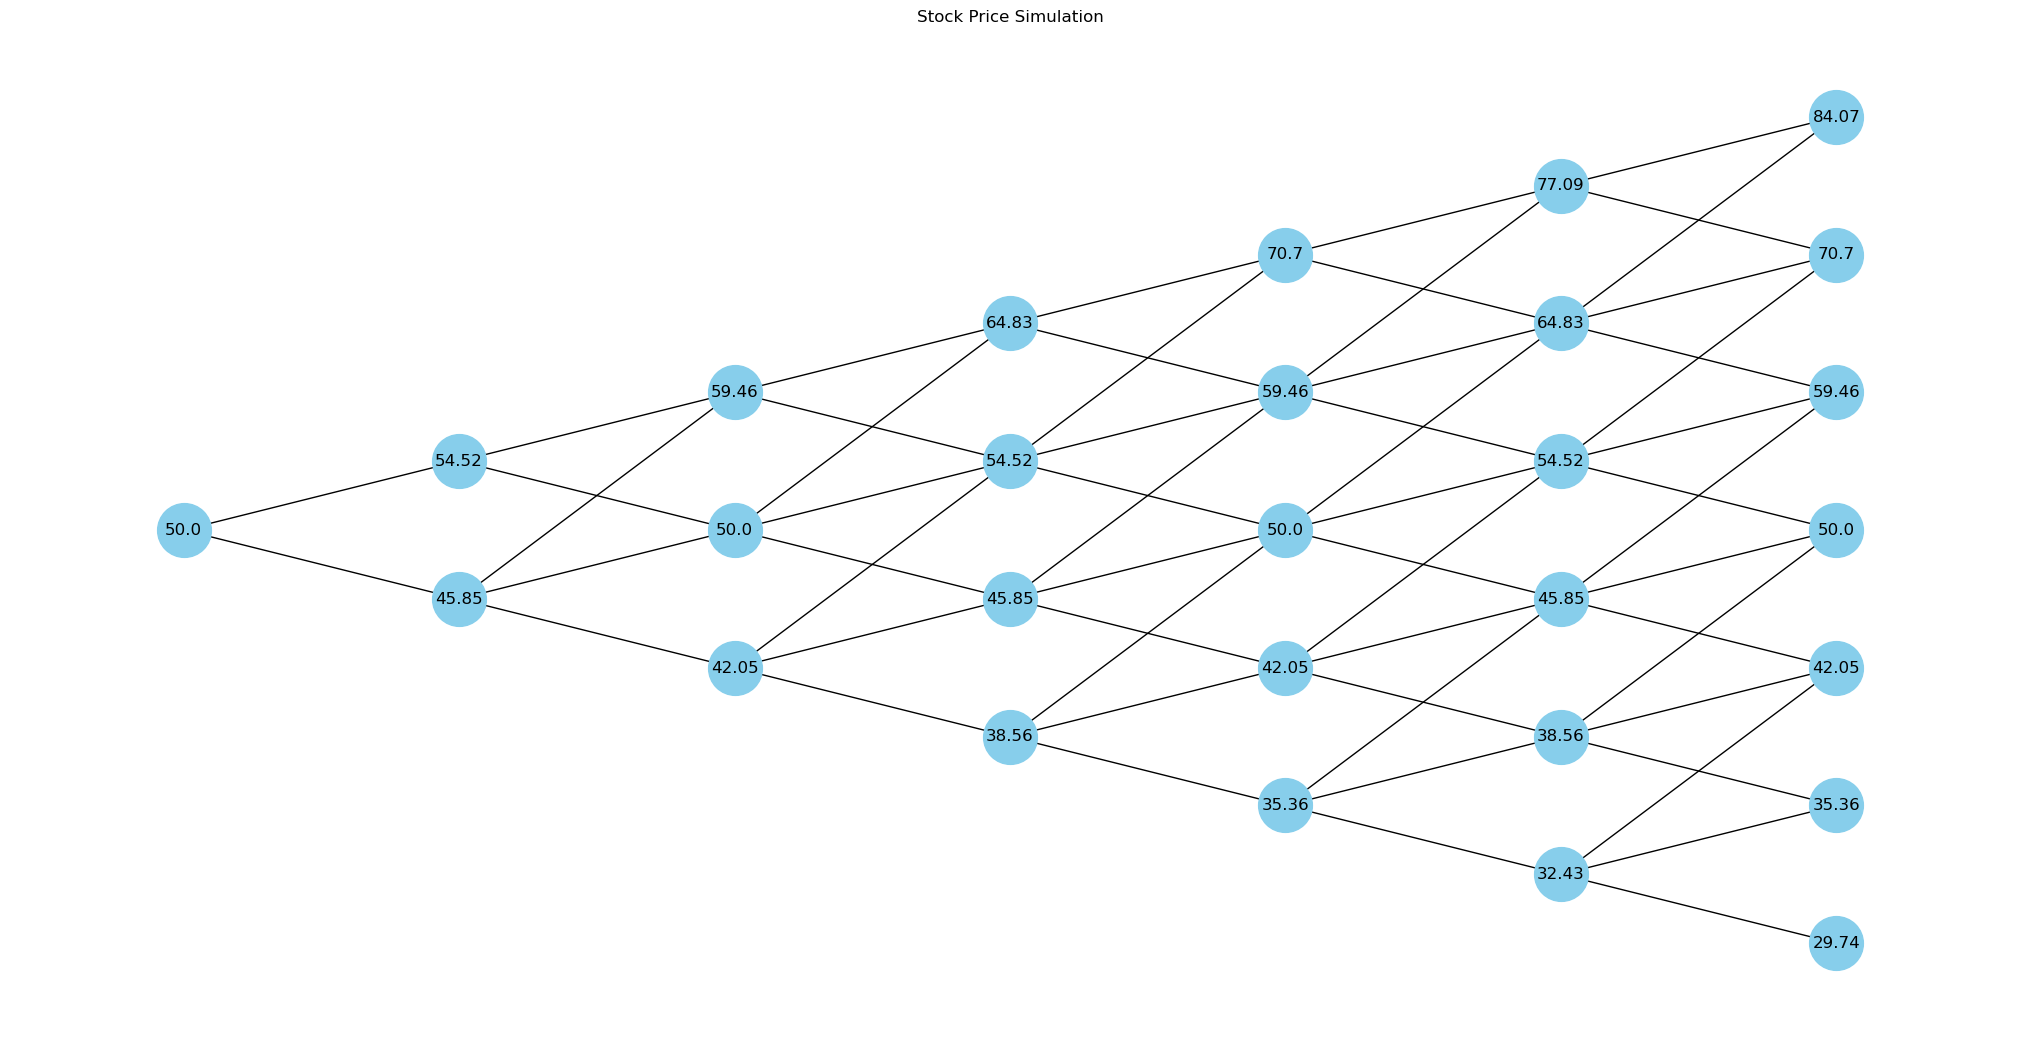

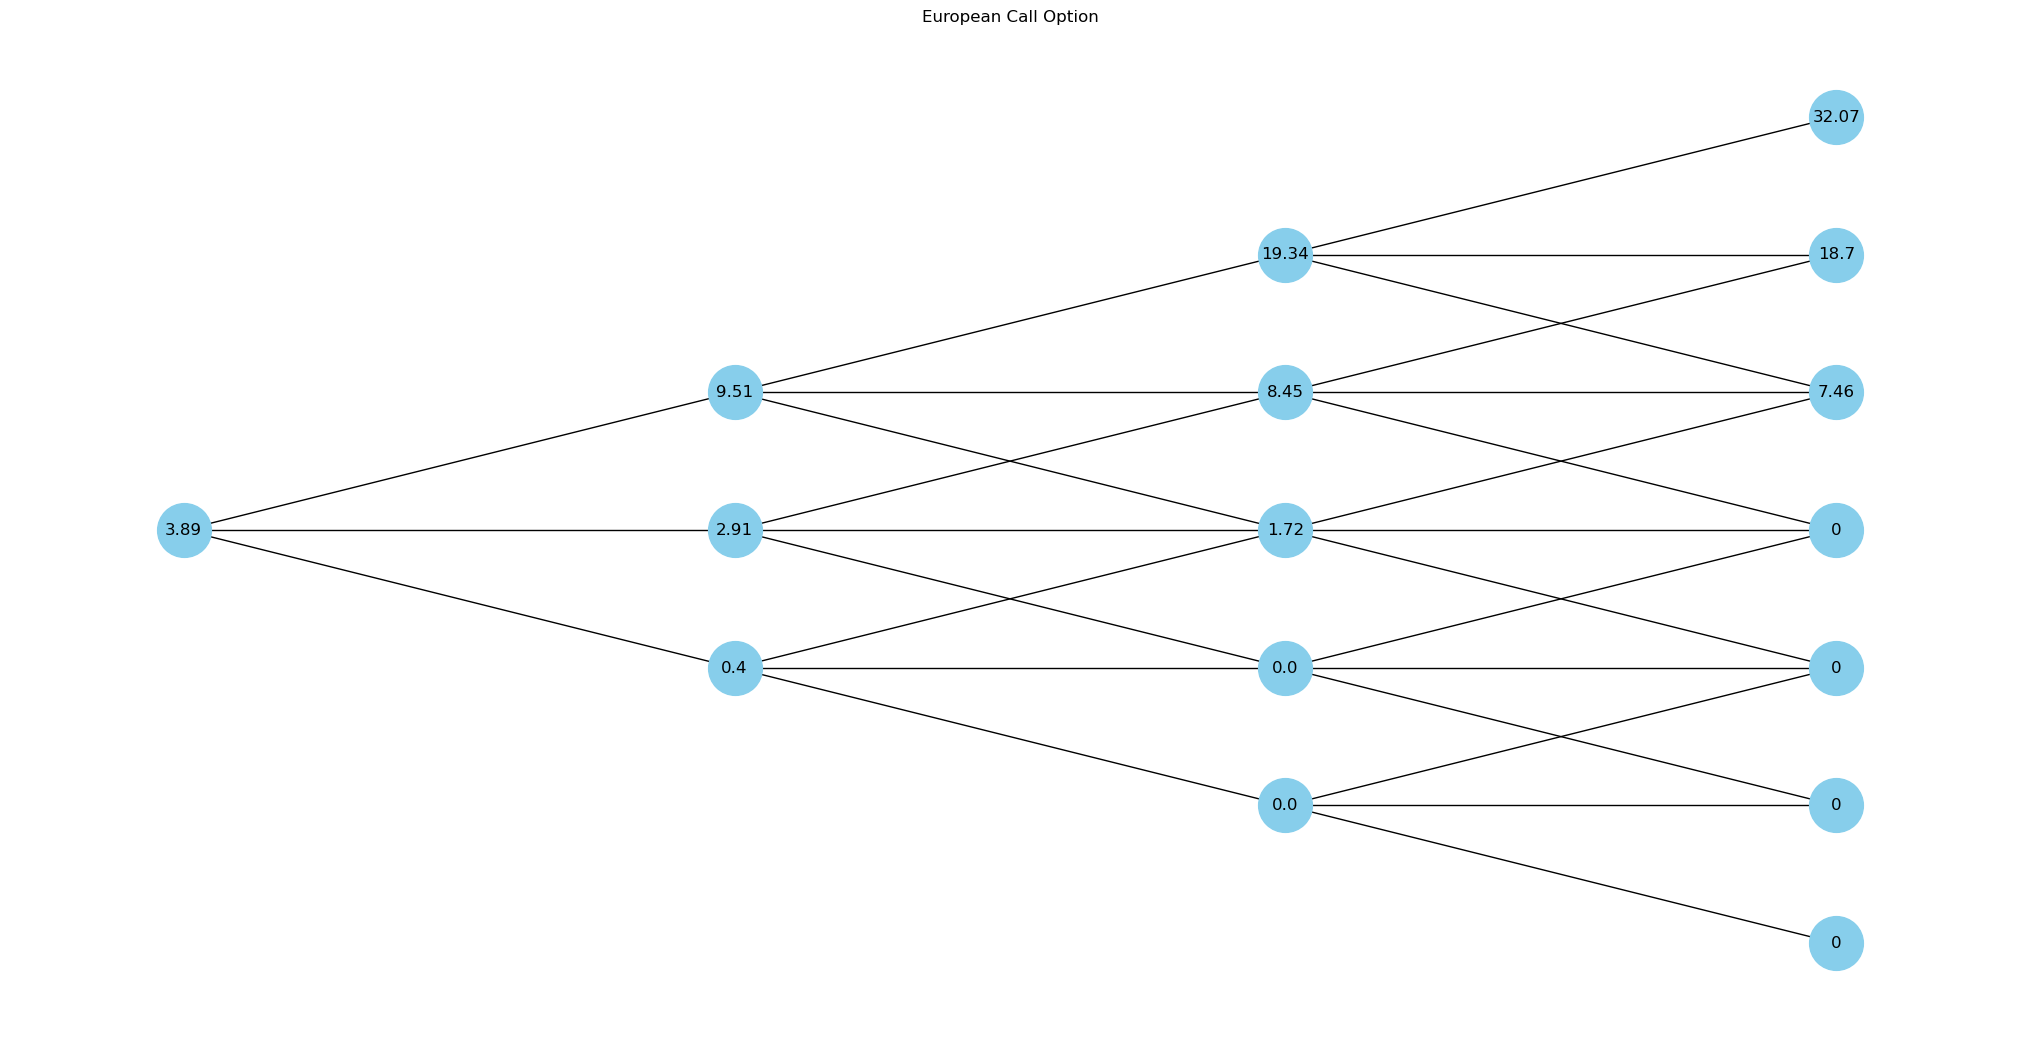

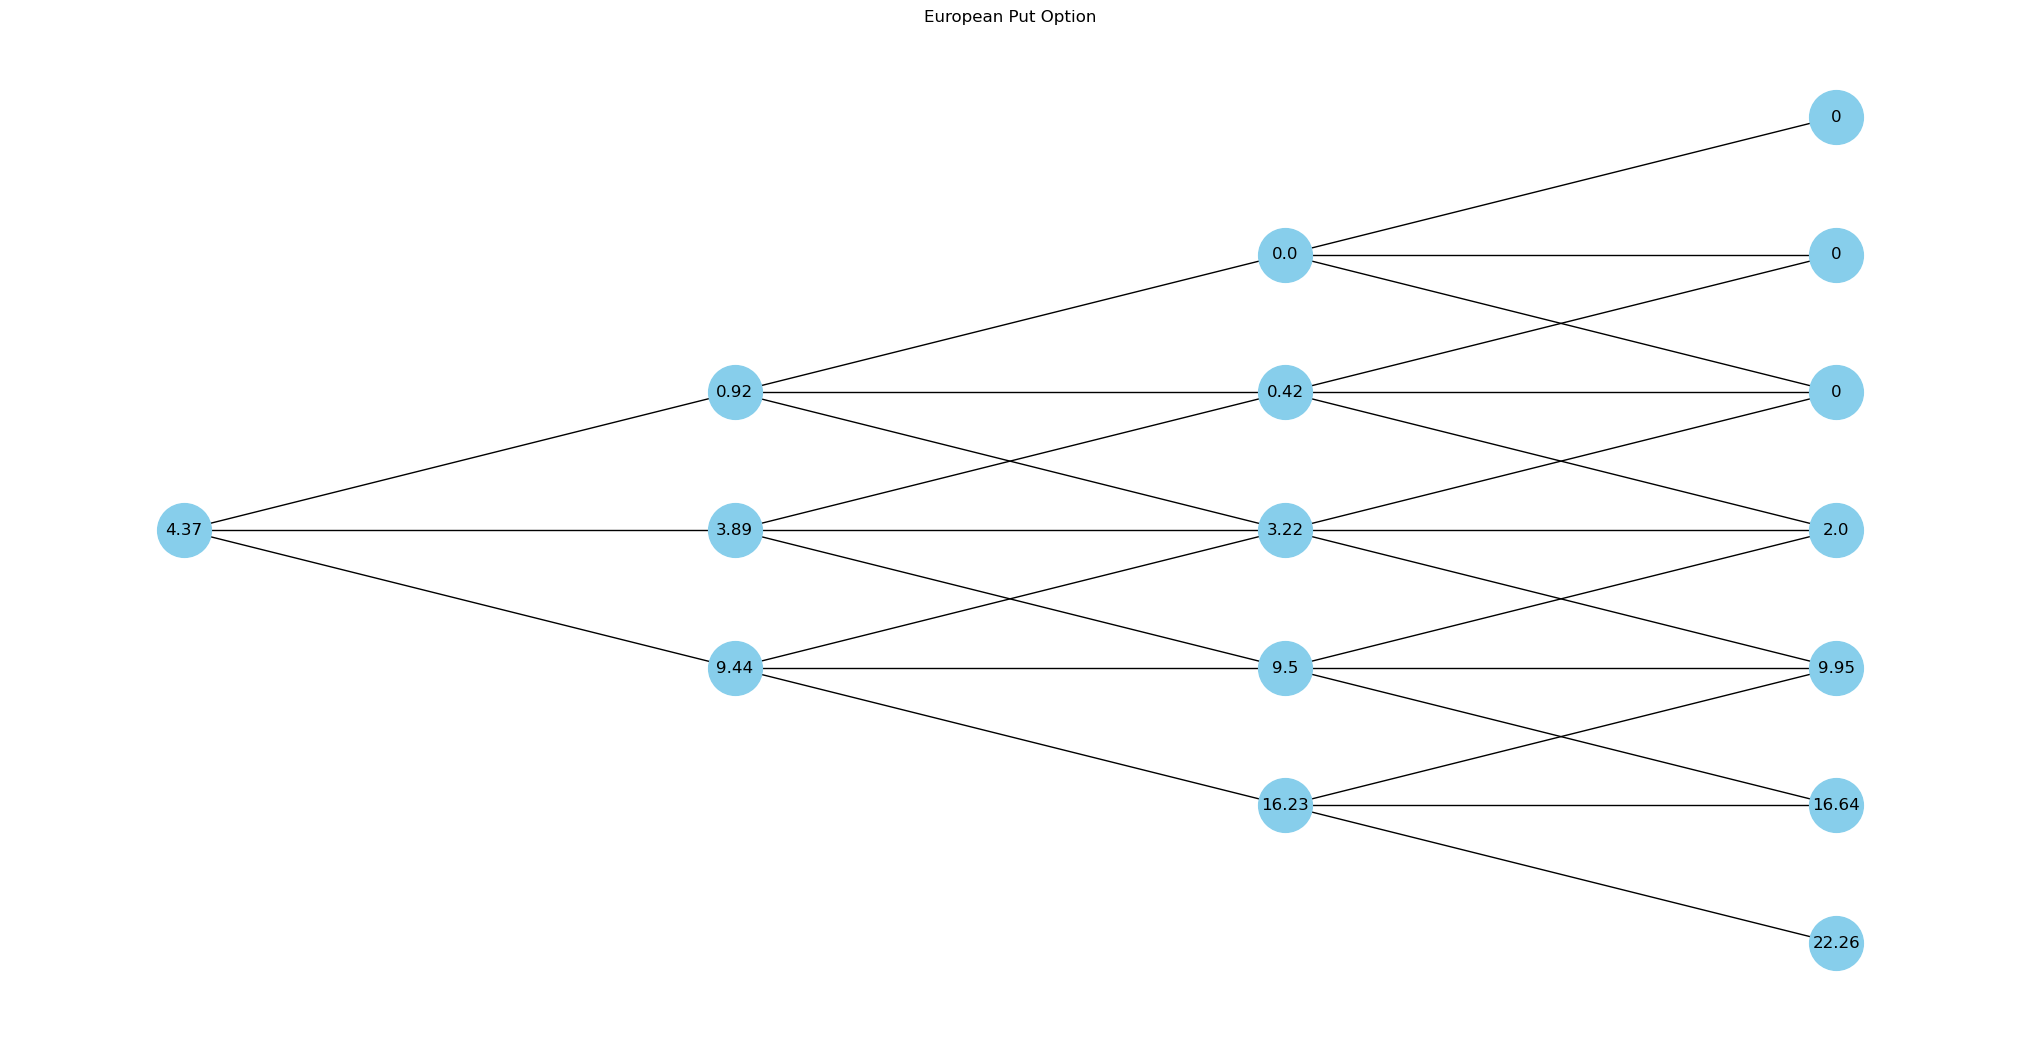

In [123]:
def usr_input():
    """Function to take user input with default values"""
    initial_price = float(input('Stock Price - S (Default: 50) --> ') or 50)
    K = float(input('Strike Price - K (Default: 52) --> ') or 52)
    sigma = float(input('Volatility - sigma (Default: 0.2) --> ') or 0.2)
    T = float(input('Time to Maturity - T (Default: 0.5) --> ') or 0.5)
    N = int(input('Periods (Default: 6) --> ') or 6)
    r = float(input('Interest Rate - r (Default: 0.04) --> ') or 0.04)
    lambdA = float(input('Lambda (Default: 1.5) --> ') or 1.5)
    
    return initial_price, K, sigma, T, N, r, lambdA

# Get user inputs
initial_price, K, sigma, T, N, r, lambdA = usr_input()

# Compute number of calculations
number_of_calculation = sum(range(N+2))

# Define node sizes and font sizes for visualization
size_of_nodes = 1500
size_of_font = 12

# Construct stock price simulation graph
plt.figure(figsize=(20, 10))
vals = construct_labels(initial_price, N, T, sigma, lambdA)
labels = construct_nodelabel(vals, N)
nodepos = construct_nodepos(vals)
G = construct_node(vals, N)

nx.set_node_attributes(G, labels, 'label')
nx.draw(G, pos=nodepos, node_color='skyblue', node_size=size_of_nodes, 
        node_shape='o', alpha=1, font_weight="bold", font_color='darkblue', 
        font_size=size_of_font)

plt.title('Stock Price Simulation')
nx.draw_networkx_labels(G, nodepos, labels)
plt.show()

# Construct European Call Option graph
plt.figure(figsize=(20, 10))
call_vals = construct_Ecallput_node(vals, K, N, r, T, lambdA, sigma, 'call')
labels = construct_nodelabel(call_vals, N)
nodepos = construct_nodepos(call_vals)
G = construct_node(call_vals, N)

nx.set_node_attributes(G, labels, 'label')
nx.draw(G, pos=nodepos, node_color='skyblue', node_size=size_of_nodes, 
        node_shape='o', alpha=1, font_weight="bold", font_color='darkblue', 
        font_size=size_of_font)

plt.title('European Call Option')
nx.draw_networkx_labels(G, nodepos, labels)
plt.show()

# Construct European Put Option graph
plt.figure(figsize=(20, 10))
put_vals = construct_Ecallput_node(vals, K, N, r, T, lambdA, sigma, 'put')
labels = construct_nodelabel(put_vals, N)
nodepos = construct_nodepos(put_vals)
G = construct_node(put_vals, N)

nx.set_node_attributes(G, labels, 'label')
nx.draw(G, pos=nodepos, node_color='skyblue', node_size=size_of_nodes, 
        node_shape='o', alpha=1, font_weight="bold", font_color='darkblue', 
        font_size=size_of_font)

plt.title('European Put Option')
nx.draw_networkx_labels(G, nodepos, labels)
plt.show()